## LangChain Expression Language (LCEL)

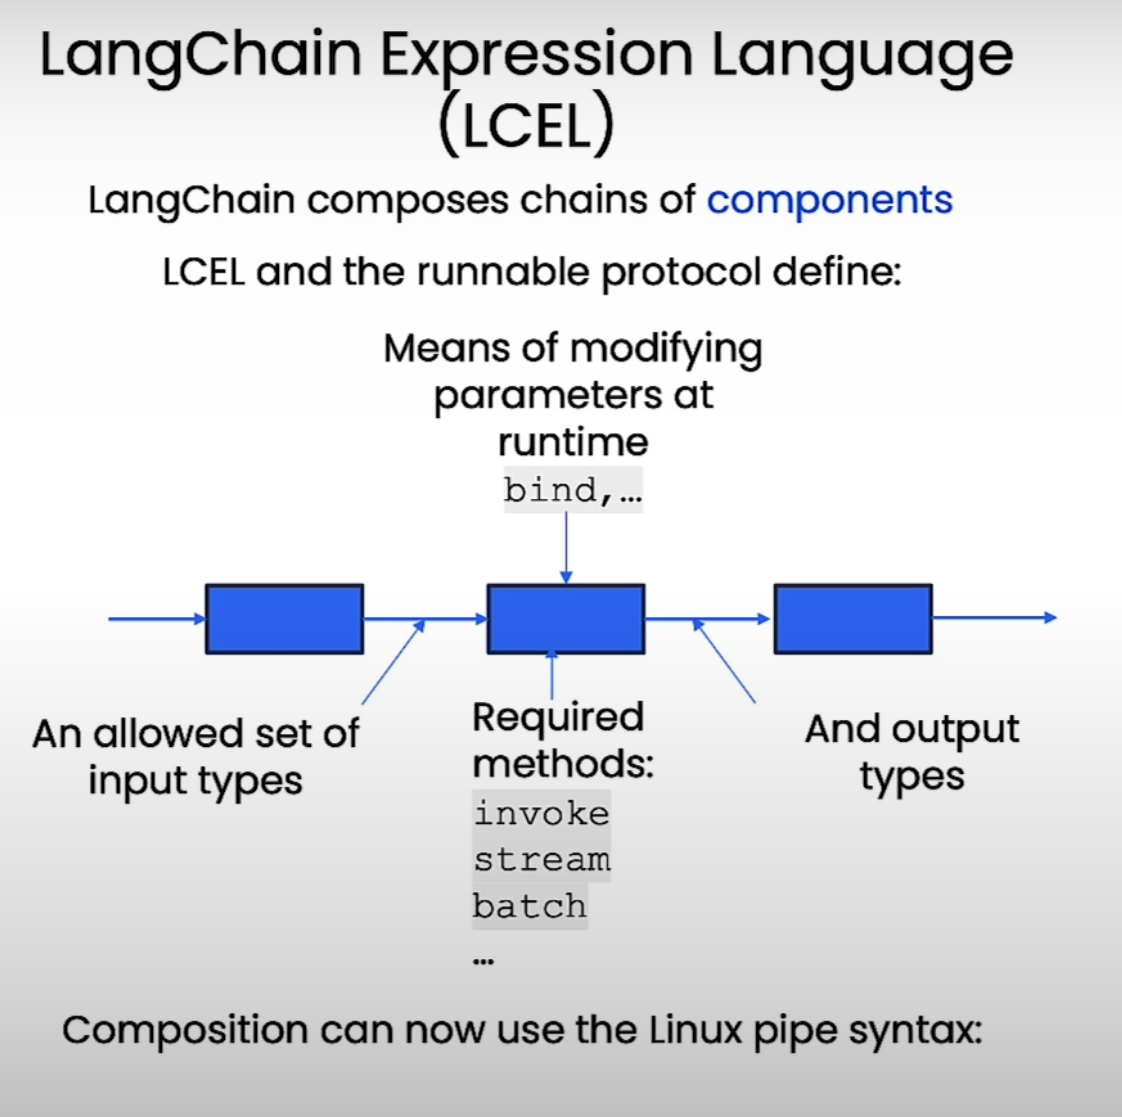

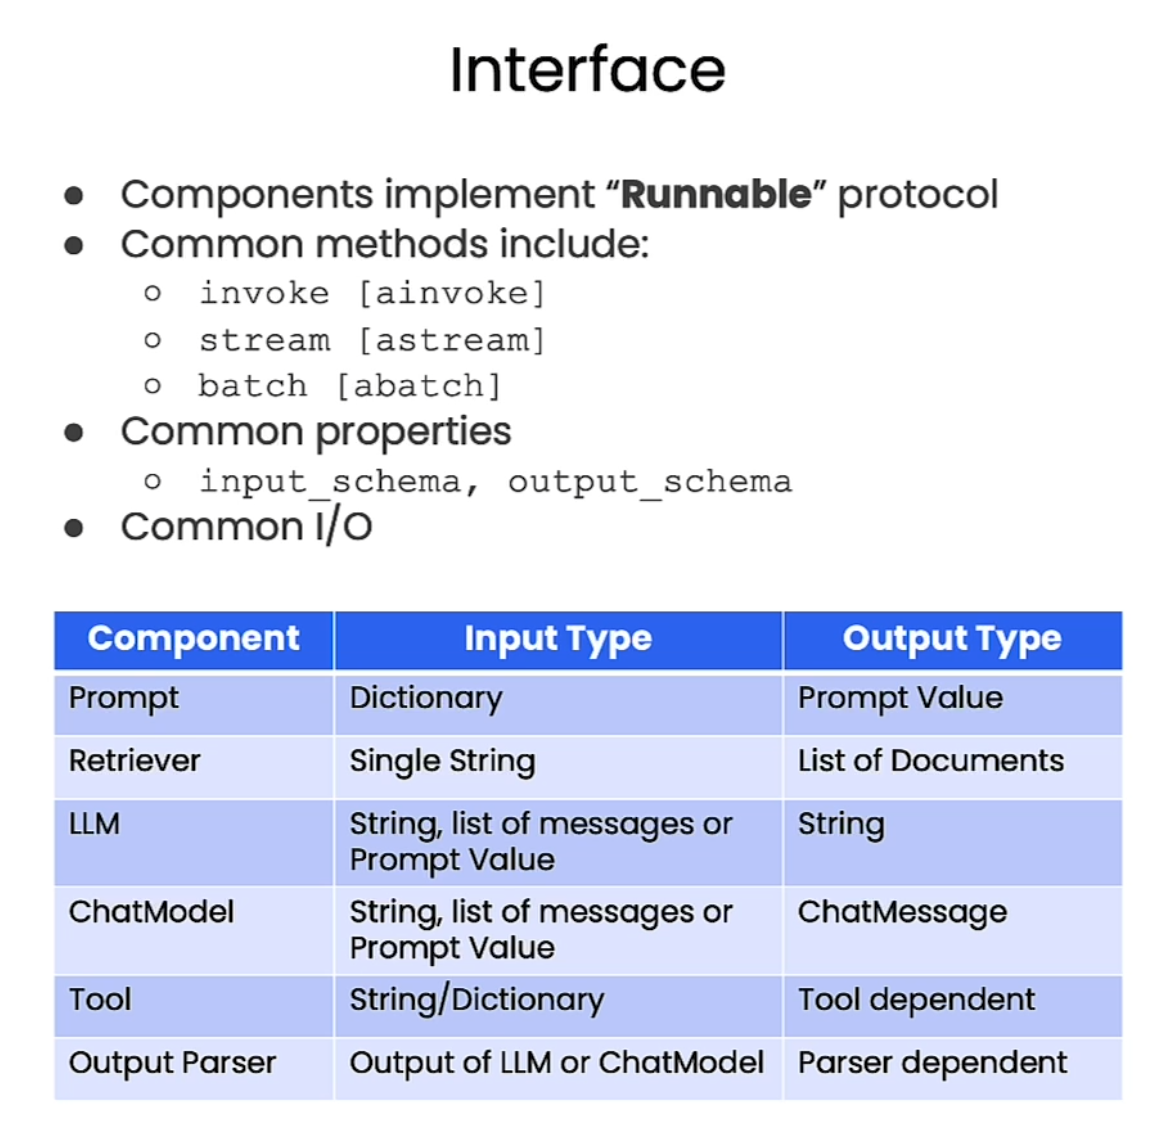
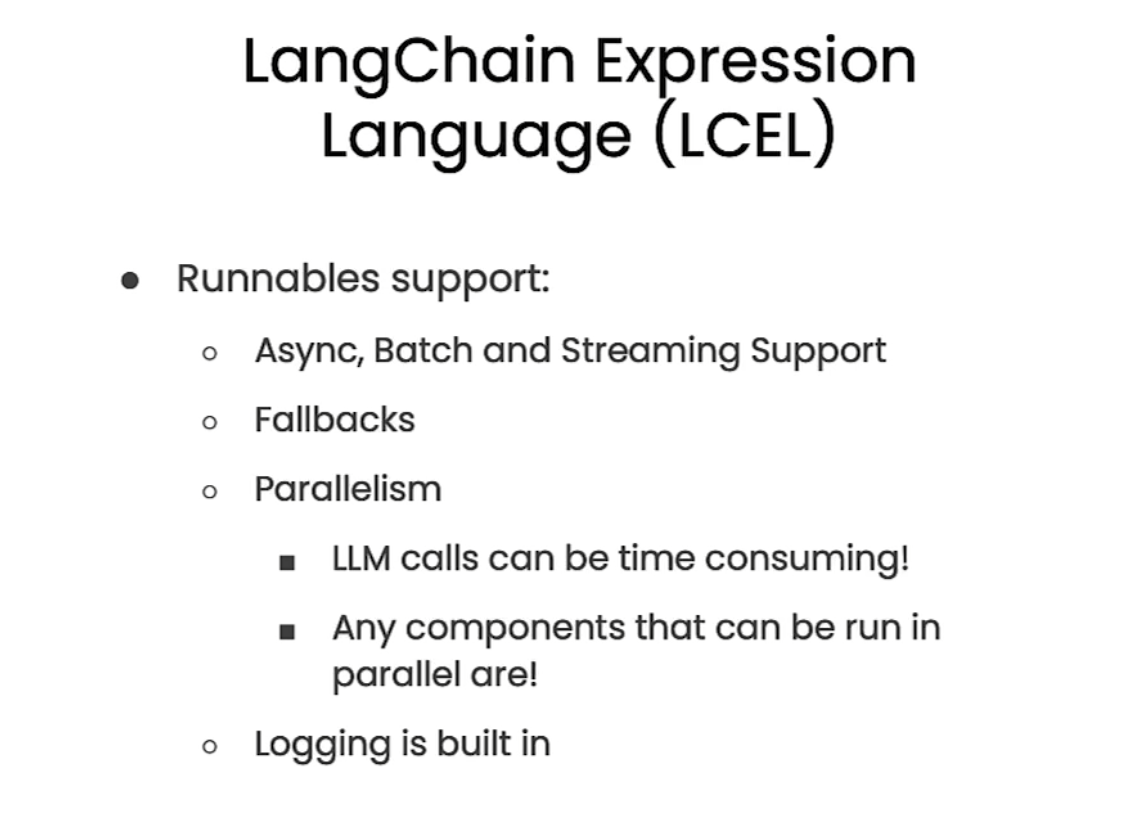

In [1]:
import os
import openai

openai.api_key = os.environ['OPENAI_API_KEY']

In [2]:
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser

In [3]:
prompt = ChatPromptTemplate.from_template(
    "tell me a short joke about {topic}"
)
model = ChatOpenAI()
output_parser = StrOutputParser()

In [4]:
chain = prompt | model | output_parser

In [5]:
chain.invoke({"topic":"Texas"})

'Why did the cowboy buy a dachshund?\n\nBecause he wanted to get a long little doggy!'

## Complex Chain

In [6]:
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import DocArrayInMemorySearch

In [21]:
vectorstore = DocArrayInMemorySearch.from_texts(
    ["harrisson worked at kensho", "bears like to eat honey"],
    embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

In [22]:
retriever.invoke("where did harrison work?")

[Document(metadata={}, page_content='harrisson worked at kensho'),
 Document(metadata={}, page_content='bears like to eat honey')]

In [23]:
retriever.invoke("what do bears like to eat")[0].page_content

'bears like to eat honey'

In [25]:
template = """Answer the question based only based on the following context:
{context}
Question: {question}"""

prompt = ChatPromptTemplate.from_template(template=template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only based on the following context:\n{context}\nQuestion: {question}'), additional_kwargs={})])

In [15]:
# first and only input to the chain will be user
# fetch relevant context
# pass that to the prompt
# pass that into the model
# pass that into the output parser to convert it into a text
# this requires RunnableMap

from langchain.schema.runnable import RunnableMap

In [26]:
chain = RunnableMap({
    "context": lambda x: retriever.invoke(x["question"]),
    "question": lambda x: x["question"]
})| prompt | model | output_parser

In [27]:
chain.invoke({"question": "where did harrison work?"})

'Harrison worked at Kensho.'

In [ ]:
inputs = RunnableMap({
    "context": lambda x: retriever.invoke(x["question"]),
    "question": lambda x: x["question"]
})| prompt | model | output_parser
inputs

{
  context: RunnableLambda(...),
  question: RunnableLambda(...)
}
| ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only based on the following context:\n{context}\nQuestion: {question}'), additional_kwargs={})])
| ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x00000251E4D12C60>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x00000251E4D4C920>, root_client=<openai.OpenAI object at 0x00000251E42DE6F0>, root_async_client=<openai.AsyncOpenAI object at 0x00000251E4D12C90>, model_kwargs={}, openai_api_key=SecretStr('**********'))
| StrOutputParser()

# Bind
an OpenAI Functions

In [ ]:
functions = [
    {
        "name": "weather_search",
        "description": "Search for weather given an airport code",
        "parameters":{
            "type": "object",
            "properties":{
                "airport_code":{
                    "type": "string",
                    "description": "The airport to get weather for"
                },
            },
            "required":["airport_code"]
        }
    },
]



In [35]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}")
    ]
)
prompt

ChatPromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={})])

In [36]:
model = ChatOpenAI(temperature=0).bind(functions = functions)
model

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x00000251844B9340>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x00000251844BA9C0>, root_client=<openai.OpenAI object at 0x00000251832289B0>, root_async_client=<openai.AsyncOpenAI object at 0x00000251844B8890>, temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'functions': [{'name': 'weather_search', 'description': 'Search for weather given an airport code', 'parameters': {'type': 'object', 'properties': {'airport_code': {'type': 'string', 'description': 'The airport to get weather for'}}, 'required': ['airport_code']}}]}, config={}, config_factories=[])

In [37]:
runnable = prompt | model
runnable.invoke({"input": "what is the weather in dfw"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"DFW"}', 'name': 'weather_search'}, 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 63, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-f724f4a6-ef9c-40bd-9214-8dff45ebc98c-0', usage_metadata={'input_tokens': 63, 'output_tokens': 16, 'total_tokens': 79, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [39]:
functions = [
    {
        "name": "weather_search",
        "description": "Search for weather given an airport code",
        "parameters":{
            "type": "object",
            "properties":{
                "airport_code":{
                    "type": "string",
                    "description": "The airport to get weather for"
                },
            },
            "required":["airport_code"]
        }
    },
      {
        "name": "sports_search",
        "description": "Search for news of recent sport events",
        "parameters":{
            "type": "object",
            "properties":{
                "team_name":{
                    "type": "string",
                    "description": "The sport team to search for"
                },
            },
            "required":["team_name"]
        }
    },
]

In [40]:
model = model.bind(functions = functions)

In [41]:
runnable = prompt | model

In [42]:
runnable.invoke({"input": "how did the patriots do yesterday"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"team_name":"New England Patriots"}', 'name': 'sports_search'}, 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 96, 'total_tokens': 114, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-831a35c3-0cbd-4d5d-8390-b5da5b429861-0', usage_metadata={'input_tokens': 96, 'output_tokens': 18, 'total_tokens': 114, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

# Fallbacks

In [45]:
from langchain_openai import OpenAI
import json

In [60]:
simple_model = OpenAI(
    temperature = 0
)
simple_chain = simple_model|  json.loads
chain = simple_model| StrOutputParser | json.loads

In [ ]:
challenge = "Write three poems in a json blob, where each open is a json blob of a title, author, and first line"


In [62]:
response = simple_model.invoke(challenge)
print(response)



{
  "title": "The Road Not Taken",
  "author": "Robert Frost",
  "first_line": "Two roads diverged in a yellow wood,"
}

{
  "title": "I Wandered Lonely as a Cloud",
  "author": "William Wordsworth",
  "first_line": "I wandered lonely as a cloud"
}

{
  "title": "Hope is the Thing with Feathers",
  "author": "Emily Dickinson",
  "first_line": "Hope is the thing with feathers"
}


In [63]:
final_chain = chain.with_fallbacks([chain])

# Interface

In [65]:
prompt = ChatPromptTemplate.from_template(
    "tell me a short joke about {topic}"
)
model = ChatOpenAI()
output_parser = StrOutputParser()
chain = prompt | model | output_parser

In [66]:
chain.invoke({"topic":"bears"})

'Why do bears have hairy coats?\n\nFur protection!'

In [67]:
chain.batch([{"topic":"potatoes"}, {"topic":"french fries"}])

['Why did the potato cross the road? Because it saw a fork up ahead!',
 'Why did the French fry go to the party? Because it was a real "tater"!']

In [68]:
for t in chain.stream({"topic": "bears"}):
    print(t)


Why
 did
 the
 bear
 bring
 a
 ladder
 to
 the
 bar
?
 

He
 heard
 the
 drinks
 were
 on
 the
 house
!



In [69]:
response = await chain.ainvoke({"topic": "bears"})

In [71]:
print(response)

Why do bears have hairy coats?

Fur protection!
